Assignment 3 - Linear regression<br>
Author: Thinh Le<br>
Date: February 13, 2025

# Introduction

Using the Python code provided by the Machine Learning in Action book (chapter 8), adapt the code to perform a linear regression on the Palmer Penguin dataset. Print coefficients and accuracy metrics (e.g. R2) and plot the actual versus predicted response variables. Document each step of the code to demonstrate you understand what each block of code does. Document what the coefficients and accuracy metrics are telling you.

# Solution

## Step 1: Import libraries

In [1]:
import pandas as pd             # Working with data
import numpy as np              # Working with arrays, vectors, lists
import matplotlib.pyplot as plt # Data visualization

## Step 2: Read the dataset and drop NAs


First, read the dataset.

In [2]:
# Read the Palmer Penguin cleaned dataset
# Note: place the dataset in the same folder with the jupyter notebook.
penguins_df = pd.read_csv('penguins_clean.csv')
penguins_df

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007
...,...,...,...,...,...,...,...,...
339,Chinstrap,Dream,55.8,19.8,207.0,4000.0,male,2009
340,Chinstrap,Dream,43.5,18.1,202.0,3400.0,female,2009
341,Chinstrap,Dream,49.6,18.2,193.0,3775.0,male,2009
342,Chinstrap,Dream,50.8,19.0,210.0,4100.0,male,2009


Drop NAs

In [3]:
# Drop NAs from the penguins_df
penguins_df.dropna(inplace=True)
# inplace=True: Drop NAs from the penguins_df directly without creating a new variable to store the new df

In [4]:
## Step 3: Read the dataset and drop NAs

## Step 2: Select independent and dependent variables ($x_1$ and $y$)

I will select two columns: **flipper length** and **body mass**, as the independent and dependent variables for the linear regression model. The reason for this choice is that when we create a scatter plot of these two columns, the points appear to follow a linear trend, making them suitable for a linear regression model.

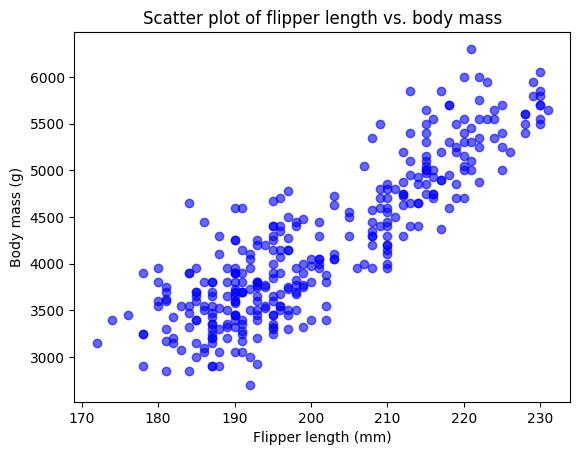

In [5]:
# Create a scatter plot
plt.scatter(
    penguins_df['flipper_length_mm'],
    penguins_df['body_mass_g'],
    color='b',
    alpha=0.6
)

# Axis labels and plot title
plt.xlabel("Flipper length (mm)")
plt.ylabel("Body mass (g)")
plt.title("Scatter plot of flipper length vs. body mass")

# Show scatter plot
plt.show()

In [6]:
# Select two columns: **flipper length** and **body mass** as the independent and dependent variables
original_data_df = penguins_df[['flipper_length_mm', 'body_mass_g']]

Note: I name it `original_data_df` because it contains all the necessary elements (except for the coefficients) and is ready to be used for predicting with a linear regression model.

Let's rename the flipper length and body mass to $x_1$ and $y$:


In [7]:
# x1 is flipper_length_mm and y is body_mass_g
original_data_df = original_data_df.rename(
    columns={'flipper_length_mm': 'X1', 'body_mass_g': 'Y'}
)
original_data_df

,X1,Y
0,181.0,3750.0
1,186.0,3800.0
2,195.0,3250.0
4,193.0,3450.0
5,190.0,3650.0
...,...,...
339,207.0,4000.0
340,202.0,3400.0
341,193.0,3775.0
342,210.0,4100.0


We need to add the bias column (which is for $x_0$ always equal 1) to the `original_data_df`.

In [8]:
# Insert a column of ones at index 0 (first column)
# shape[0]: number of rows of the original_data_df
original_data_df.insert(0, 'X0', np.ones(original_data_df.shape[0]))
original_data_df

,X0,X1,Y
0,1.0,181.0,3750.0
1,1.0,186.0,3800.0
2,1.0,195.0,3250.0
4,1.0,193.0,3450.0
5,1.0,190.0,3650.0
...,...,...,...
339,1.0,207.0,4000.0
340,1.0,202.0,3400.0
341,1.0,193.0,3775.0
342,1.0,210.0,4100.0


## Step 3: Split training and testing data from `original_data_df`

We split the `original_data_df` into 2 subsets for training and testing to evaluate the model’s performance on unseen data.

First, shuffle the `original_data_df`.

In [9]:
# sample(): change the order of rows
#   frac= 1  : all the rows will be shuffled
#   frac= 0.5: 50% of the rows will be shuffled
original_data_df = original_data_df.sample(frac = 1)
original_data_df

,X0,X1,Y
94,1.0,187.0,3300.0
323,1.0,212.0,4300.0
152,1.0,211.0,4500.0
155,1.0,218.0,5700.0
266,1.0,217.0,4375.0
...,...,...,...
215,1.0,231.0,5650.0
46,1.0,182.0,3425.0
232,1.0,212.0,4625.0
317,1.0,187.0,3650.0


Note: Shuffling prevents the model from learning patterns based on the order of the data, ensuring it focuses on the actual relationships between independent and dependent variables.

Next, I will pick 75% of data for training and 25% for testing.

In [10]:
# Define the ratio for training and testing data
ratio = 0.75

# Calculate the split index
# shape[0]: number of rows of the original_data_df
# Convert the value to integer
split_index = int(original_data_df.shape[0] * ratio)
split_index

249

In [11]:
# Get training data from the first row to split_index row - 1
training_df = original_data_df[0:split_index]
training_df

,X0,X1,Y
94,1.0,187.0,3300.0
323,1.0,212.0,4300.0
152,1.0,211.0,4500.0
155,1.0,218.0,5700.0
266,1.0,217.0,4375.0
...,...,...,...
260,1.0,208.0,4575.0
26,1.0,183.0,3550.0
283,1.0,197.0,3750.0
279,1.0,188.0,3525.0


In [12]:
# Get test data from the split_index row to end.
testing_df = original_data_df[split_index:]
testing_df

,X0,X1,Y
76,1.0,191.0,3700.0
188,1.0,213.0,4950.0
244,1.0,212.0,4750.0
117,1.0,199.0,3775.0
277,1.0,196.0,3900.0
...,...,...,...
215,1.0,231.0,5650.0
46,1.0,182.0,3425.0
232,1.0,212.0,4625.0
317,1.0,187.0,3650.0


## Step 4: Create training and testing matrices for the independent and dependent variables (X(s) and Y)

In [13]:
training_X_matrix = np.asmatrix(training_df[['X0', 'X1']])
training_X_matrix

matrix([[  1., 187.],
        [  1., 212.],
        [  1., 211.],
        [  1., 218.],
        [  1., 217.],
        [  1., 195.],
        [  1., 190.],
        [  1., 222.],
        [  1., 194.],
        [  1., 212.],
        [  1., 193.],
        [  1., 193.],
        [  1., 213.],
        [  1., 196.],
        [  1., 190.],
        [  1., 217.],
        [  1., 201.],
        [  1., 180.],
        [  1., 218.],
        [  1., 180.],
        [  1., 203.],
        [  1., 196.],
        [  1., 186.],
        [  1., 190.],
        [  1., 191.],
        [  1., 207.],
        [  1., 174.],
        [  1., 186.],
        [  1., 195.],
        [  1., 172.],
        [  1., 193.],
        [  1., 222.],
        [  1., 195.],
        [  1., 219.],
        [  1., 192.],
        [  1., 221.],
        [  1., 209.],
        [  1., 187.],
        [  1., 198.],
        [  1., 228.],
        [  1., 193.],
        [  1., 205.],
        [  1., 201.],
        [  1., 203.],
        [  1., 205.],
        [ 

In [14]:
training_Y_matrix = np.asmatrix(training_df[['Y']])
training_Y_matrix

matrix([[3300.],
        [4300.],
        [4500.],
        [5700.],
        [4375.],
        [3850.],
        [3325.],
        [5550.],
        [3775.],
        [4750.],
        [3800.],
        [3450.],
        [4400.],
        [4400.],
        [3950.],
        [5850.],
        [4050.],
        [3800.],
        [5700.],
        [3950.],
        [4100.],
        [4075.],
        [3100.],
        [3450.],
        [3800.],
        [4000.],
        [3400.],
        [3500.],
        [3325.],
        [3150.],
        [3750.],
        [4875.],
        [3600.],
        [5500.],
        [4050.],
        [6300.],
        [4400.],
        [3150.],
        [3825.],
        [5400.],
        [3800.],
        [4300.],
        [4050.],
        [4725.],
        [4550.],
        [4900.],
        [5000.],
        [3950.],
        [4450.],
        [4150.],
        [5850.],
        [3950.],
        [3700.],
        [4700.],
        [6000.],
        [4200.],
        [5400.],
        [5750.],
        [3975.

In [15]:
testing_X_matrix = np.asmatrix(testing_df[['X0', 'X1']])
testing_X_matrix

matrix([[  1., 191.],
        [  1., 213.],
        [  1., 212.],
        [  1., 199.],
        [  1., 196.],
        [  1., 211.],
        [  1., 184.],
        [  1., 199.],
        [  1., 178.],
        [  1., 192.],
        [  1., 195.],
        [  1., 190.],
        [  1., 193.],
        [  1., 189.],
        [  1., 210.],
        [  1., 191.],
        [  1., 191.],
        [  1., 225.],
        [  1., 186.],
        [  1., 230.],
        [  1., 188.],
        [  1., 195.],
        [  1., 221.],
        [  1., 190.],
        [  1., 195.],
        [  1., 219.],
        [  1., 198.],
        [  1., 209.],
        [  1., 205.],
        [  1., 215.],
        [  1., 187.],
        [  1., 221.],
        [  1., 218.],
        [  1., 216.],
        [  1., 202.],
        [  1., 198.],
        [  1., 230.],
        [  1., 181.],
        [  1., 189.],
        [  1., 210.],
        [  1., 207.],
        [  1., 195.],
        [  1., 214.],
        [  1., 187.],
        [  1., 208.],
        [ 

In [16]:
testing_Y_matrix = np.asmatrix(testing_df[['Y']])
testing_Y_matrix

matrix([[3700.],
        [4950.],
        [4750.],
        [3775.],
        [3900.],
        [4800.],
        [4650.],
        [3900.],
        [3250.],
        [4100.],
        [3300.],
        [3400.],
        [3200.],
        [3325.],
        [4150.],
        [3250.],
        [3175.],
        [5000.],
        [3050.],
        [5550.],
        [3300.],
        [4250.],
        [5100.],
        [3050.],
        [4400.],
        [5250.],
        [4450.],
        [4700.],
        [4500.],
        [5300.],
        [3250.],
        [5300.],
        [4600.],
        [4925.],
        [3550.],
        [3675.],
        [5700.],
        [3700.],
        [3800.],
        [4300.],
        [5050.],
        [4000.],
        [4400.],
        [2900.],
        [4300.],
        [3575.],
        [4050.],
        [3450.],
        [3725.],
        [4250.],
        [3200.],
        [2850.],
        [3600.],
        [3550.],
        [4400.],
        [4000.],
        [3500.],
        [5550.],
        [4650.

## Step 5: Calculate the estimated regression coefficient matrix ($\hat{\beta}$) using the Ordinary Least Squares (OLS) method

$$
\hat{\beta} = (X^T X)^{-1} X^T Y
$$

In [17]:
# Create a function to calculate the estimated regression coefficient matrix
def calculate_estimated_coefficient_matrix(_training_X_df, _training_Y_df):
    # Calculate the transpose of X matrix with X matrix (Gram matrix)
    gram_matrix = _training_X_df.T * _training_X_df

    # Check if gram_matrix is a singular matrix
    if np.linalg.det(gram_matrix) == 0.0:
        print("This matrix is singular, cannot do inverse")
        return

    return gram_matrix.I * (_training_X_df.T * _training_Y_df)

coefficient_matrix = calculate_estimated_coefficient_matrix(
    training_X_matrix,
    training_Y_matrix
)
coefficient_matrix

matrix([[-5863.95697515],
        [   50.22926749]])

## Step 6: Calculate the training and testing predicted value matrix ($\hat{Y}$)

$$
\hat{Y} = \hat{\beta}X
$$

In [18]:
training_Y_hat_matrix = training_X_matrix * coefficient_matrix
training_Y_hat_matrix

matrix([[3528.9160464 ],
        [4784.64773377],
        [4734.41846628],
        [5086.02333874],
        [5035.79407125],
        [3930.75018636],
        [3679.60384888],
        [5286.94040872],
        [3880.52091886],
        [4784.64773377],
        [3830.29165137],
        [3830.29165137],
        [4834.87700127],
        [3980.97945385],
        [3679.60384888],
        [5035.79407125],
        [4232.12579133],
        [3177.31117393],
        [5086.02333874],
        [3177.31117393],
        [4332.58432632],
        [3980.97945385],
        [3478.6867789 ],
        [3679.60384888],
        [3729.83311638],
        [4533.5013963 ],
        [2875.93556896],
        [3478.6867789 ],
        [3930.75018636],
        [2775.47703397],
        [3830.29165137],
        [5286.94040872],
        [3930.75018636],
        [5136.25260624],
        [3780.06238387],
        [5236.71114123],
        [4633.95993129],
        [3528.9160464 ],
        [4081.43798884],
        [5588.31601369],


In [19]:
testing_Y_hat_matrix = testing_X_matrix * coefficient_matrix
testing_Y_hat_matrix

matrix([[3729.83311638],
        [4834.87700127],
        [4784.64773377],
        [4131.66725634],
        [3980.97945385],
        [4734.41846628],
        [3378.22824391],
        [4131.66725634],
        [3076.85263894],
        [3780.06238387],
        [3930.75018636],
        [3679.60384888],
        [3830.29165137],
        [3629.37458139],
        [4684.18919878],
        [3729.83311638],
        [3729.83311638],
        [5437.62821121],
        [3478.6867789 ],
        [5688.77454868],
        [3579.14531389],
        [3930.75018636],
        [5236.71114123],
        [3679.60384888],
        [3930.75018636],
        [5136.25260624],
        [4081.43798884],
        [4633.95993129],
        [4433.04286131],
        [4935.33553626],
        [3528.9160464 ],
        [5236.71114123],
        [5086.02333874],
        [4985.56480375],
        [4282.35505882],
        [4081.43798884],
        [5688.77454868],
        [3227.54044143],
        [3629.37458139],
        [4684.18919878],


## Step 7: Calculate coefficient of determination ($R^2$) of training data and testing data

$$
R^2 = 1 - \frac{\sum (y_i - \hat{y}_i)^2}{\sum (y_i - \bar{y})^2}
$$

Define a function to calculate the Residual Sum of Squares (RSS)

In [20]:
def calculate_rss(_Y_array, _Y_hat_array):
    residual_matrix = _Y_array - _Y_hat_array
    return np.sum(residual_matrix ** 2)

Define a function to calculate the Total Sum of Squares (TSS)

In [21]:
def calculate_tss(_Y_array):
    Y_mean = np.mean(_Y_array)
    return np.sum((_Y_array - Y_mean) ** 2)

Define a function to calculate the coefficient of determination ($R^2$)

In [22]:
def calculate_r_square(_Y_array, _Y_hat_array):
    rss = calculate_rss(_Y_array, _Y_hat_array)
    tss = calculate_tss(_Y_array)
    return 1 - rss / tss

The coefficient of determination ($R^2$) of training data

In [23]:
r_square_training = calculate_r_square(
    np.asarray(training_Y_matrix), np.asarray(training_Y_hat_matrix)
)
r_square_training

np.float64(0.7684647177574819)

The coefficient of determination ($R^2$) of testing data

In [24]:
r_square_testing = calculate_r_square(
    np.asarray(testing_Y_matrix), np.asarray(testing_Y_hat_matrix)
)
r_square_testing

np.float64(0.7263054390698249)

The R-squared values for both the training and testing datasets are very good. This suggests that the model is generalizing well to the testing data and is not overfitting the training data.

## Step 8: plot data

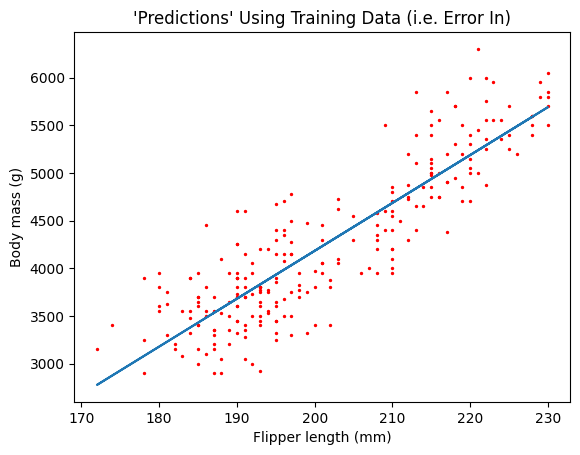

In [26]:
fig = plt.figure()
# Add a subplot to the figure (this creates a 1x1 grid and places the plot in position 1)
ax = fig.add_subplot(111)

# Create a scatter plot with points in red circles, size = 2
ax.scatter(np.asarray(training_X_matrix)[:, 1], # Get only X1 data
           np.asarray(training_Y_matrix)[:, 0],
           s=2,
           c='red')

# Create a line plot for the linear regression model
ax.plot(np.asarray(training_X_matrix)[:, 1],
        np.asarray(training_Y_hat_matrix)[:,0])

# Add labels and plot title
ax.set_xlabel('Flipper length (mm)')
ax.set_ylabel('Body mass (g)')
plt.title("'Predictions' Using Training Data (i.e. Error In)")

# Show the plots
plt.show()